(P) Project: ML for NLP
- Perform sentiment analysis using SVM and Naive Bayes and compare the results.

- https://github.com/undertheseanlp/NLP-Vietnamese-progress/blob/master/tasks/sentiment_analysis.md?authuser=0
- https://www.kaggle.com/datasets/tuannguyenvananh/vietnamese-text-classification-dataset?authuser=0

0: negative,
1: neutral
2: positive.

In [34]:
# Import libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from sklearn.ensemble import BaggingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (accuracy_score, auc, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import (cross_val_score, GridSearchCV,
                                     RandomizedSearchCV, train_test_split)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC

In [35]:
# Load data

data = pd.read_csv('/content/train.csv', header=None, names=['label', 'reviews'])

In [36]:
data.head(1)

,label,reviews
0,0,máy dùng hay bị đơ máy


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    3040 non-null   int64 
 1   reviews  3040 non-null   object
dtypes: int64(1), object(1)
memory usage: 47.6+ KB


In [38]:
# https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords.txt

def load_stopwords(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        stop_words = set(f.read().splitlines())
    return stop_words

# using available list vietnamese stopwords on github
stop_words = load_stopwords('/content/vietnamese-stopwords.txt')

In [39]:
# Preprocessing

def normalize_text(text): # Normalization
  text = text.lower()
  text = re.sub(r'\s', ' ', text)
  text = re.sub(r'[^\w\s]', '', text)
  return text

def preprocess_text(text):
    content = normalize_text(text)     # Nomalize text

    content = ' '.join([word for word in content.split() if word not in stop_words])    # Remove stopwords

    # add any further step if needed

    return content

In [40]:
data['cleaned_reviews'] = data['reviews'].apply(preprocess_text)

In [41]:
data.head(10)

,label,reviews,cleaned_reviews
0,0,máy dùng hay bị đơ máy,máy đơ máy
1,0,chỉ có dây cáp nguồn không có adapter sao sử d...,dây cáp adapter sử dụng dây cáp adapter sử dụn...
2,0,Chất lượng quá kém Mới dùng được 2 ngày loa ba...,chất kém 2 loa bass âm rè rè tưởng chất
3,0,Usb tôi vừa mới nhận usb này Rất bực bội vì cá...,usb usb bực bội nắp usb cứng thể hộp đựng usb ...
4,2,Tuyệt vời. Hàng FPT cửa hàng,tuyệt vời hàng fpt cửa hàng
5,1,Chưa đo đúng bước chân rõ Nhiều khi gián đoạn ...,đo chân gián đoạn hài hàng tiếng việt hoạt độn...
6,0,phủ sóng thấp quá đi khoảng 3 4m là mất sóng,phủ sóng đi 3 4m sóng
7,1,Kết nối tốt Mối nối không khít gây đau tai 1 K...,kết nối nối khít đau tai 1 kết nối vấn đề kết ...
8,0,2 Loa nhỏ nghe bị rè Âm thanh chưa tốt hơi thấ...,2 loa rè âm hơi thất vọng sản phẩm dây cắm 2 l...
9,0,Đặt i12 shop giao i11 thất vọng,i12 shop giao i11 thất vọng


In [42]:
# Split Train, Test

X = data['cleaned_reviews']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Tokenize data

# Tokenize reviews data using TF-IDF. TF-IDF is better for text classification than CountVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [44]:
# Multinomial Naive Bayes

# Training
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Predict
y_pred_nb = nb_model.predict(X_test_tfidf)

In [45]:
# MultinomialNB with Bagging

# Training
bagged_nb_model = BaggingClassifier(estimator=MultinomialNB(), n_estimators=10, random_state=42)
bagged_nb_model.fit(X_train_tfidf, y_train)

# Predict
y_pred_bagged_nb = bagged_nb_model.predict(X_test_tfidf)

In [46]:
# SVM

# Training
svm_model = SVC(kernel='linear')  # Using kernel 'linear' because it works well for text classification
svm_model.fit(X_train_tfidf, y_train)

# Predict
y_pred_svm = svm_model.predict(X_test_tfidf)

In [47]:
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Bagged Multinomial Naive Bayes': BaggingClassifier(MultinomialNB(), n_estimators=10, random_state=42),
    'SVM': SVC(kernel='linear')
}

y_preds = [
    y_pred_nb,
    y_pred_bagged_nb,
    y_pred_svm
]

In [48]:
def evaluate_models(y_test, y_preds, model_names):
    results = []

    for y_pred, model_name in zip(y_preds, models):
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        rec = recall_score(y_test, y_pred, average='weighted')
        prec = precision_score(y_test, y_pred, average='weighted')

        results.append([model_name, acc, f1, rec, prec])

    return pd.DataFrame(results, columns=['Model', 'Accuracy_Score', 'F1_Score', 'Recall_Score', 'Precision_Score'])

In [49]:
def cross_validate_models(models, X, y, cv):
    results = []
    for model_name, model in models.items():
        scores = cross_val_score(model, X, y, cv=cv)
        results.append({
            'Model': model_name,
            'Mean Accuracy': scores.mean(),
            'Standard Deviation': scores.std()
        })
    return pd.DataFrame(results)

In [50]:
# Model evaluation

evla_results = evaluate_models(y_test, y_preds, models)
evla_results

,Model,Accuracy_Score,F1_Score,Recall_Score,Precision_Score
0,Multinomial Naive Bayes,0.726974,0.718089,0.726974,0.727612
1,Bagged Multinomial Naive Bayes,0.723684,0.714498,0.723684,0.722131
2,SVM,0.738487,0.735269,0.738487,0.734834


In [51]:
# Cross validation

cross_validation_results = cross_validate_models(models, X_train_tfidf, y_train, cv=10)  # data has 3040 rows, start with k = 10 to evaluate model
cross_validation_results

,Model,Mean Accuracy,Standard Deviation
0,Multinomial Naive Bayes,0.717092,0.012994
1,Bagged Multinomial Naive Bayes,0.717921,0.011364
2,SVM,0.732305,0.019697


In [52]:
# Cross validation

cross_validation_results = cross_validate_models(models, X_train_tfidf, y_train, cv=5)  # data has 3040 rows, continue try with k = 5
cross_validation_results

,Model,Mean Accuracy,Standard Deviation
0,Multinomial Naive Bayes,0.715452,0.010987
1,Bagged Multinomial Naive Bayes,0.715454,0.009157
2,SVM,0.724091,0.015773


# SVM has the best accuracy (00.724) => Use this model to perform sentiment analysis

In [53]:
# Find best parameter

In [55]:
# instantiate classifier with default hyperparameters with kernel=rbf, C=1.0 and gamma=auto
svc=SVC()

# declare parameters for hyperparameter tuning
parameters = {'C':[1, 10, 100, 1000], 'kernel':['linear']}

grid_search = GridSearchCV(estimator = svc,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

grid_search.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000], 'kernel': ['linear']},
             scoring='accuracy')

In [56]:
# examine the best model


# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))


# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))


# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

GridSearch CV best score : 0.7241


Parameters that give the best results : 

 {'C': 1, 'kernel': 'linear'}


Estimator that was chosen by the search : 

 SVC(C=1, kernel='linear')


In [57]:
# calculate GridSearch CV score on test set

print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_test_tfidf, y_test)))

GridSearch CV score on test set: 0.7385


In [58]:
# Final model

# Training
svm_model_hp_tuning = SVC(kernel='linear', C = 1)
svm_model_hp_tuning.fit(X_train_tfidf, y_train)

# Predict
y_pred_svm_hp_tuning = svm_model_hp_tuning.predict(X_test_tfidf)

In [59]:
acc = accuracy_score(y_test, y_pred_svm_hp_tuning)
f1 = f1_score(y_test, y_pred_svm_hp_tuning, average='weighted')
rec = recall_score(y_test, y_pred_svm_hp_tuning, average='weighted')
prec = precision_score(y_test, y_pred_svm_hp_tuning, average='weighted')
evla_results = pd.DataFrame([['Final Hypertuned SVM', acc, f1, rec, prec]],
                      columns=['Model', 'Accuracy_Score', 'F1_Score', 'Recall_Score', 'Precision_Score'])

evla_results

,Model,Accuracy_Score,F1_Score,Recall_Score,Precision_Score
0,Final Hypertuned SVM,0.738487,0.735269,0.738487,0.734834


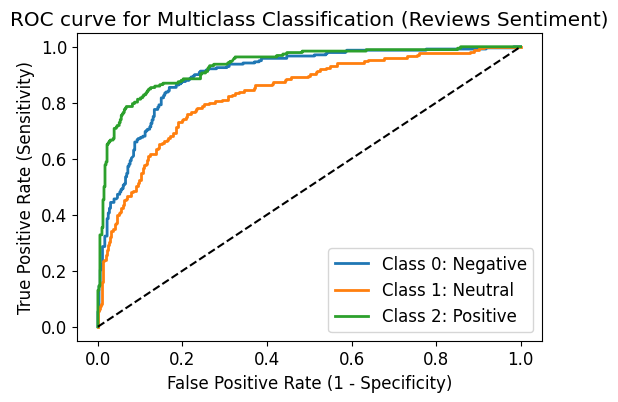

In [60]:
# y_test has 3 three labels: negative, neutral và positive
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# One-vs-Rest classifier with an SVM using a linear kernel
classifier = OneVsRestClassifier(SVC(kernel='linear', C = 1, probability=True))  # Set probability=True enables probability estimates (useful for ROC/AUC calculations)
classifier.fit(X_train_tfidf, y_train)

# Predict
y_score = classifier.predict_proba(X_test_tfidf)

# Calculate ROC Curve for each class
fpr = dict()
tpr = dict()
for i in range(3):  # 3 class
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])

# ROC curve for each class
plt.figure(figsize=(6, 4))
for i in range(3):
    plt.plot(fpr[i], tpr[i], linewidth=2, label=f'Class {i}: {["Negative", "Neutral", "Positive"][i]}')

plt.plot([0, 1], [0, 1], 'k--')

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Multiclass Classification (Reviews Sentiment)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.show()


In [61]:
# Predict probability scores for the test data using the trained classifier
y_score = classifier.predict_proba(X_test_tfidf)

# Calculate the ROC AUC score for the test data
# The multi_class='ovr' argument specifies the One-vs-Rest strategy for multi-class classification
ROC_AUC = roc_auc_score(y_test, y_score, multi_class='ovr')

print('ROC AUC (One-vs-Rest) : {:.4f}'.format(ROC_AUC))

ROC AUC (One-vs-Rest) : 0.8891


In [62]:
# unknown pattern

# unknown_review = "Laptop này dùng chán, chạy rất chậm, tôi thật sự không thích"
# unknown_review = "Laptop này dùng cũng bình thường"
unknown_review = "Chiếc laptop này ngoại hình sang trọng, lúc đầu dùng thấy chạy mượt, ổn, tuy nhiên dùng được một thời gian thì loa bắt đầu rè, màn hình hay có triệu chứng bị đơ. Với mức giá rẻ như thế này mình không đòi hỏi gì hơn. Các bạn cần dùng hiệu năng cao thì không nên mua lap này nhé."

preprocessed_review = preprocess_text(unknown_review)

review_tfidf = vectorizer.transform([preprocessed_review])

predicted_class = svm_model_hp_tuning.predict(review_tfidf)

# predicted_class
sentiment = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

sentiment[predicted_class[0]]

'Neutral'